In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import warnings
import numpy as np
from numpy import where
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from PIL import Image
from PIL import ImageEnhance
import cv2

from sklearn import preprocessing

from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay,f1_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.compose import make_column_selector as selector

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten, Dropout, Input
from tensorflow.keras.optimizers import Adam

In [ ]:
import zipfile

# Unzipping the images
# zip_ref = zipfile.ZipFile("/content/drive/MyDrive/AI_project/images.zip", 'r')
# zip_ref.extractall("/content/drive/MyDrive/AI_project/")
# zip_ref.close()

In [ ]:
import os

# The path to the images folder on google drive
path = '/content/drive/MyDrive/AI_project/eye-images'

normal = os.path.join(path,'1_normal/')
cataract = os.path.join(path,'2_cataract/')
glaucoma = os.path.join(path,'2_glaucoma/')
print("Number of Normal eye dataset", len(os.listdir(normal)))
print("Number of Cataract dataset", len(os.listdir(cataract)))
print("Number of Glaucoma dataset", len(os.listdir(glaucoma)))


Number of Normal eye dataset 300
Number of Cataract dataset 100
Number of Glaucoma dataset 101


In [ ]:
## Load the file names from all directories
normal_images = os.listdir(normal)
cataract_images =  os.listdir(cataract)
glaucoma_images =  os.listdir(glaucoma)

In [ ]:
import math

def display_images(directory, image_list, num_images, title="Images", images_per_row=5):
    """
    Displays a specified number of images from a given directory in rows for better viewing.

    Parameters:
    - directory (str): Path to the directory containing images.
    - image_list (list): List of image file names in the directory.
    - num_images (int): Number of images to display.
    - title (str): Title for the displayed images (default: "Images").
    - images_per_row (int): Number of images to display per row (default: 5).

    Returns:
    - None
    """
    # Validate the number of images
    if num_images > len(image_list):
        raise ValueError(f"Requested {num_images} images, but only {len(image_list)} are available.")

    # Calculate the number of rows needed
    num_rows = math.ceil(num_images / images_per_row)

    # Plot the images
    plt.figure(figsize=(images_per_row * 3, num_rows * 3))  # Adjust the figure size dynamically
    for i, image_name in enumerate(image_list[:num_images]):
        img_path = os.path.join(directory, image_name)
        img = Image.open(img_path)

        # Determine subplot position
        plt.subplot(num_rows, images_per_row, i + 1)
        plt.imshow(img)
        plt.title(f"{title} {i + 1}", fontsize=8)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

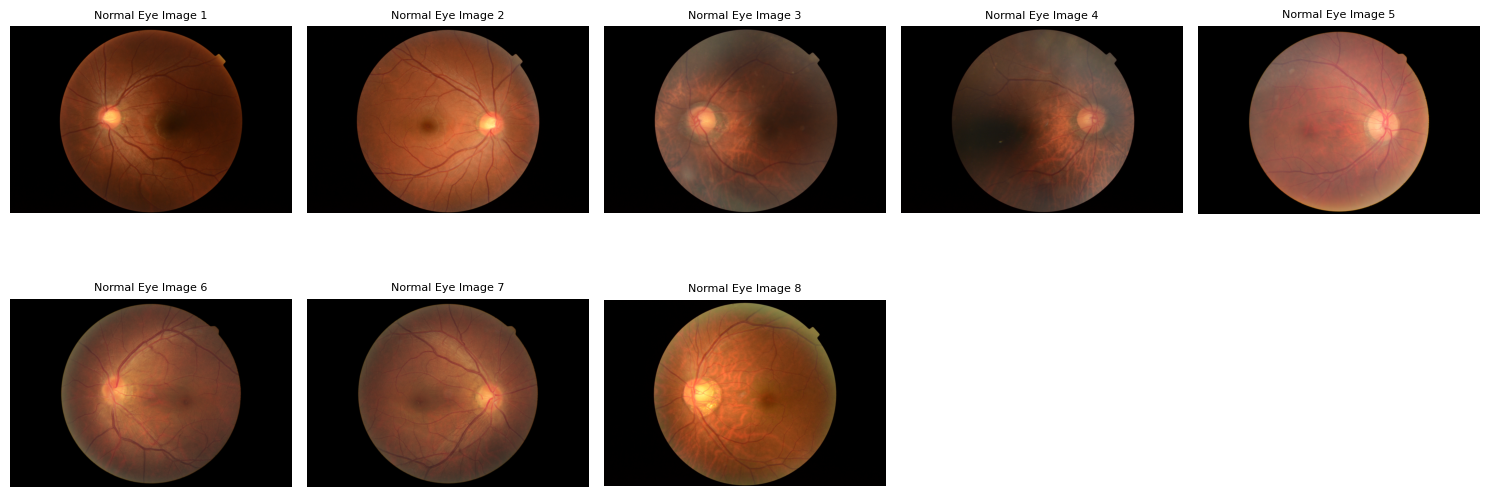

In [ ]:
display_images(normal,
               normal_images,
               num_images=8,
               title="Normal Eye Image")

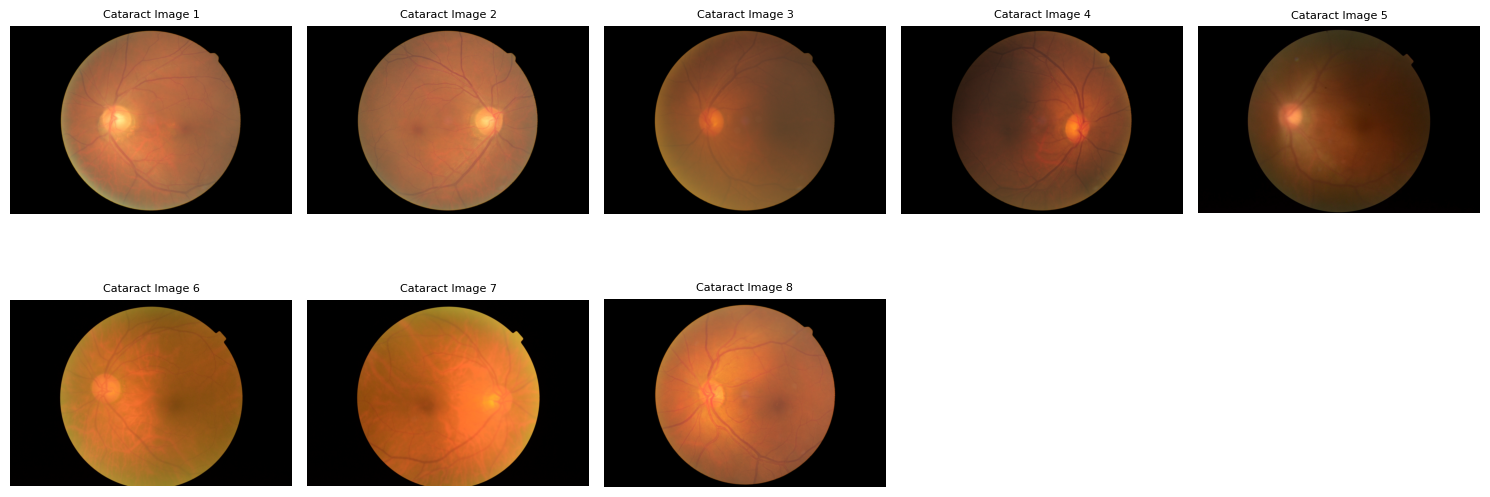

In [ ]:
display_images(cataract,
               cataract_images,
               num_images=8,
               title="Cataract Image")

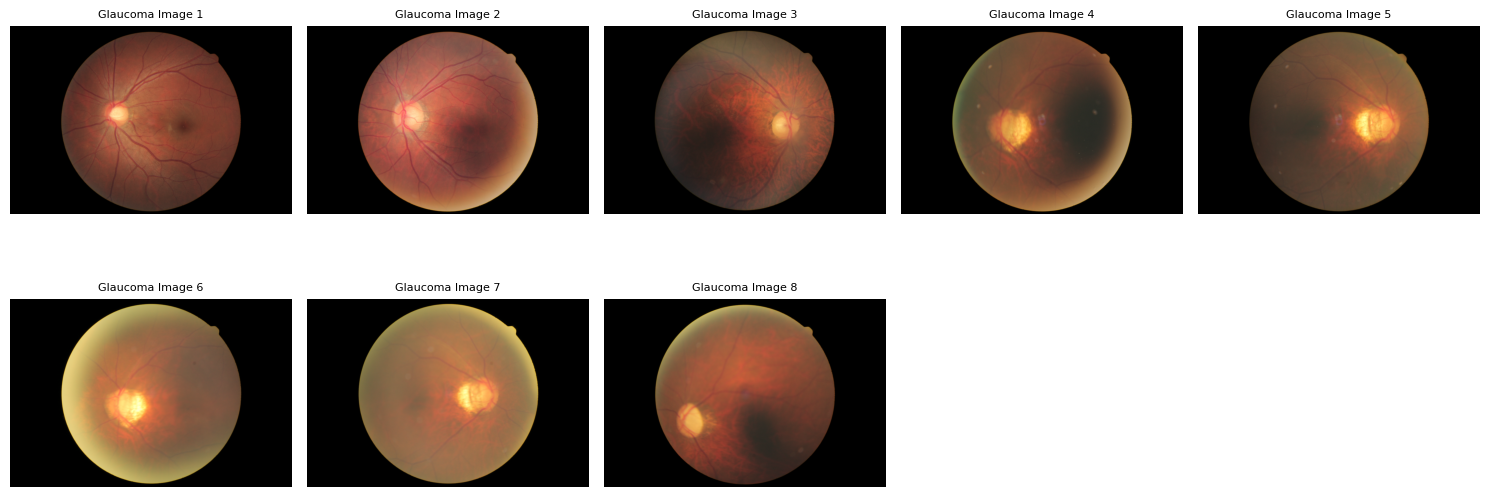

In [ ]:
display_images(glaucoma,
               glaucoma_images,
               num_images=8,
               title="Glaucoma Image")

Quality Control of the Datasets

The following code chunk verifies the image integrity using the the Pillow package and provides flexibility to choose between sequential and parallel processing. Sequential processing is simple and suitable for small datasets, while parallel processing accelerates the validation of large datasets by utilizing multiple threads. Users can toggle between these options using a parameter, optimizing the process based on dataset size and system resources.

In [ ]:
from concurrent.futures import ThreadPoolExecutor

# This function accepts the path to a single file and checks if its corrupt or not
def is_image_corrupt(file_path):
    try:
        with Image.open(file_path) as img:
            img.verify()  # Verify the integrity of the image
        return None  # return None if image is valid
    except Exception:
        return file_path  # If corrupt, return file path

# This function allows the validation of images in a folder by sequential or parallel processing methods
def find_corrupt_images(image_dir, use_parallel=True, max_workers=4):

    # Collect all image files in the directory
    image_files = [
        os.path.join(image_dir, file)
        for file in os.listdir(image_dir)
        if file.lower().endswith(('.png', '.jpeg'))
    ]

    if use_parallel:
        # Parallel processing using ThreadPoolExecutor
        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            corrupt_files = list(filter(None, executor.map(is_image_corrupt, image_files)))
    else:
        # Sequential processing
        corrupt_files = [file for file in image_files if is_image_corrupt(file)]

    return corrupt_files

# To remove corrupt files from the ML pipeline, if any
def remove_corrupt_images(image_dir, corrupt_files):
    for corrupt_file in corrupt_files:
        os.remove(corrupt_file)  # Remove the corrupt file
        print(f"Removed corrupted file: {corrupt_file}")

Checking for corrupted files in the image folders

In [ ]:
folders = [normal, cataract, glaucoma]

for folder in folders:
    folder_name = os.path.basename(os.path.normpath(folder))
    print(f"Checking for corrupted files in {folder_name}...")

    # Using sequential image validation as the dataset is small.
    corrupt_files = find_corrupt_images(folder, use_parallel=False)

    if corrupt_files:
        print(f"Corrupted files in {folder_name}:")
        print("\n".join(corrupt_files))
        remove_corrupt_images(folder, corrupt_files)
    else:
        print(f"No corrupted files found in {folder_name}.")
    print("-" * 50)


Checking for corrupted files in 1_normal...
No corrupted files found in 1_normal.
--------------------------------------------------
Checking for corrupted files in 2_cataract...
No corrupted files found in 2_cataract.
--------------------------------------------------
Checking for corrupted files in 2_glaucoma...
No corrupted files found in 2_glaucoma.
--------------------------------------------------


In [ ]:
import cv2  # used to read images

# Note - it resizes all images to 100x100

def load_images(directories, n_images=900000):
    """
    Reads in images and assigns class labels
    Parameters:
        directories: A list of the sub-directories
        n_images:    The maximum number of images to load from each directory
    Returns:
        images (numpy.ndarray) : Image data
        label (numpy.ndarray      : Labels of each image
    """
    images = []
    labels = []
    for label, sub_dir in enumerate(directories):
        num=1
        for file_name in os.listdir(sub_dir):
            if num > n_images:
                break
            img_path = os.path.join(sub_dir, file_name)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (100, 100))  # Resize to a smaller, consistent shape
                #gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                #images.append(gray_image)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                images.append(img)
                labels.append(label)
                num+=1
    return np.array(images), np.array(labels)

In [ ]:
images, labels = load_images([normal, cataract, glaucoma])

In [ ]:
images.shape

(501, 100, 100, 3)

In [ ]:
# Import required package
from sklearn.model_selection import train_test_split

# Spliting data into training + validation and test set (80% train+val, 20% test)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    images, labels, test_size=0.2, random_state=42
)

# Further spliting training + validation into training and validation sets (e.g., 75% train, 25% val)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42
)  # 0.25 x 0.8 = 0.2 (20% of total data for validation)

# Convert labels to categorical for training, validation, and test sets
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=3)
y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes=3)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=3)

In [ ]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (300, 100, 100, 3)
y_train shape: (300,)


In [ ]:
from collections import Counter

print(Counter(y_train))
print(Counter(y_test))

Counter({0: 179, 2: 61, 1: 60})
Counter({0: 53, 2: 28, 1: 20})


In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, RandomFlip, RandomRotation, RandomZoom, RandomTranslation, RandomBrightness, GaussianNoise, Rescaling, Resizing

data_augmentation = Sequential([

    Input(shape=(100, 100, 3)),
    RandomFlip("horizontal"),  # Only horizontal flips for anatomical realism
    RandomRotation(0.1),  # Small rotations to simulate slight capture variations
    RandomZoom(0.1),  # Minor zoom variations
    RandomTranslation(0.1, 0.1),  # Handle slight misalignments
    GaussianNoise(0.05),  # Add subtle noise for robustness
    Rescaling(1./255)  # Normalize pixel values to [0, 1]

])


In [ ]:
pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.8 MB/s eta 0:00:00


In [23]:
from kerastuner.tuners import Hyperband
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Compute class weights
def compute_class_weights(y_train):
    """
    Compute class weights to handle class imbalance.
    """
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    return {i: weight for i, weight in enumerate(class_weights)}

# Model builder function
def model_builder(hp):
    """
    Build the CNN model with hyperparameter tuning, including decreasing neurons in dense layers.
    """
    model = tf.keras.Sequential()

    # Add the data augmentation model as the first layer
    model.add(data_augmentation)

    # Tune the number of convolutional layers
    num_conv_layers = hp.Int('num_conv_layers', min_value=1, max_value=3)
    for i in range(num_conv_layers):
        model.add(tf.keras.layers.Conv2D(
            filters=hp.Int(f'conv_{i+1}_filters', min_value=32, max_value=128, step=32),
            kernel_size=hp.Choice(f'conv_{i+1}_kernel', values=[3, 5]),
            activation='relu'
        ))
        model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(tf.keras.layers.Flatten())

    # Tune the number of dense layers
    num_dense_layers = hp.Int('num_dense_layers', min_value=1, max_value=3)

    # Initial number of units for the first dense layer
    initial_units = hp.Int('initial_dense_units', min_value=128, max_value=512, step=64)
    for i in range(num_dense_layers):
        # Decrease units by a factor of 2 with each subsequent layer
        units = max(initial_units // (2**i), 32)  # Ensure units don't drop below 32
        model.add(tf.keras.layers.Dense(units, activation='relu'))

    # Output layer
    model.add(tf.keras.layers.Dense(3, activation='softmax'))  # Assuming 3 classes

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        ),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
# One-hot encode labels for categorical cross-entropy
from tensorflow.keras.utils import to_categorical
y_train_categorical = to_categorical(y_train, num_classes=3)
y_val_categorical = to_categorical(y_val, num_classes=3)

# Compute class weights
class_weights = compute_class_weights(y_train)

# Initialize the tuner
tuner = Hyperband(
    model_builder,
    objective='val_accuracy',
    max_epochs=30,
    executions_per_trial=2,
    directory='/content/drive/MyDrive/AI_project/ModelOptimisationResults',
    project_name='cnn_with_augmentation_and_class_weights'
)

# Perform hyperparameter tuning
tuner.search(
    X_train, y_train_categorical,
    validation_data=(X_val, y_val_categorical),
    epochs=30,
    callbacks=[early_stopping],
    batch_size=32,
    class_weight=class_weights
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(
    X_train, y_train_categorical,
    validation_data=(X_val, y_val_categorical),
    epochs=50,
    callbacks=[early_stopping],
    batch_size=32,
    class_weight=class_weights
)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 0.2309 - loss: 1.2138 - val_accuracy: 0.1200 - val_loss: 1.1030
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.2508 - loss: 1.0400 - val_accuracy: 0.1400 - val_loss: 1.0906
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.2276 - loss: 1.1278 - val_accuracy: 0.1200 - val_loss: 1.0868
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.2552 - loss: 1.0903 - val_accuracy: 0.6700 - val_loss: 1.0584
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.5162 - loss: 1.0870 - val_accuracy: 0.5100 - val_loss: 1.0346
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3586 - loss: 1.0942 - val_accuracy: 0.1800 - val_loss: 1.0429
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4072 - loss: 1.0499 - val_accuracy: 0.2400 - val_loss: 1.1111
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.2302 - loss: 1.0900 - val_accuracy: 0.2000 - v